# Lec 23: Confidence Intervals & The Bootstrap 
***

We'll need Numpy, Matplotlib, Pandas, and scipy.stats for this notebook, so let's load them. 

In [3]:
import numpy as np 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

import math

## Inference: Estimation

In [4]:
sf = pd.read_csv('san_francisco_2019.csv')
sf.head()

,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
0,Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332.0,0.0,40059.0,131391.0
1,Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241.0,0.0,49279.0,172520.0
2,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715.0,0.0,46752.0,162468.0
3,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Principal,159394.0,0.0,57312.0,216706.0
4,Public Protection,Adult Probation,Information Systems,IS Programmer Analyst,70035.0,0.0,28671.0,98706.0


Suppose we're interested in a histogram of the `Total Compensation` Distribution:

array([[<AxesSubplot:title={'center':'Total Compensation'}>]],
      dtype=object)

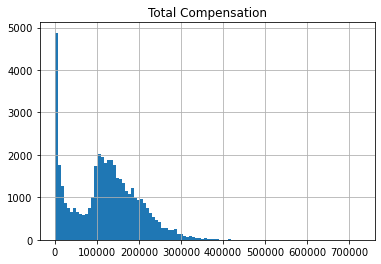

In [264]:
# Population Total Compensation Distribution 


sf.hist('Total Compensation', bins=100)

In [265]:
# Who made the most money
sf['Total Compensation'].sort_values(ascending=False).head()

43936    724031.0
43937    617951.0
43938    617554.0
43940    571784.0
43939    570235.0
Name: Total Compensation, dtype: float64

In [229]:
# Who made the least money
sf['Total Compensation'].sort_values().head()

18526    0.0
43234    0.0
22329    0.0
32865    0.0
38732    0.0
Name: Total Compensation, dtype: float64

array([[<AxesSubplot:title={'center':'Total Compensation'}>]],
      dtype=object)

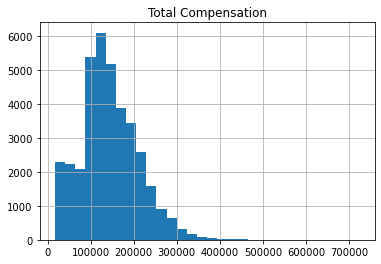

In [267]:
# Use Cutoff for Min Salary:  People working at minimum wage part-time:
# $15/hr, 20 hr/wk, 52 weeks
min_salary = 15 * 20 * 52
sf = sf[sf["Salary"]>=min_salary]

sf_bins = np.arange(0, 726000, 25000)

sf.hist('Total Compensation', bins=30)

In [268]:
pop_median = sf['Total Compensation'].median()
pop_median

136164.0

array([[<AxesSubplot:title={'center':'Total Compensation'}>]],
      dtype=object)

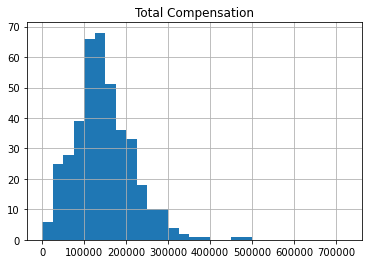

In [289]:
# Empirical Distribution of One Random Sample
sample_size = 400
orig_sample = sf.sample(sample_size,replace=False)
orig_sample.hist('Total Compensation', bins=sf_bins)

In [81]:
# Parameter: Median Total Compensation 
pop_median = sf['Total Compensation'].median()
pop_median

136164.0

In [279]:
# Estimate: Median of a Sample
orig_sample["Total Compensation"].median()

138231.0

However, our random sample *could have been different*. Then our estimate would have been different too. To see how different, we need another sample.


## Variability of the Estimate

In [ ]:
def generate_sample_median(samp_size):
    new_sample = sf.sample(samp_size, replace=False)
    return new_sample['Total Compensation'].median()

In [11]:
FUN_NAME(400)

381099.0

In [12]:
repetitions=10000
SIM_VALS=np.array([])

for i in np.arange(repetitions):
    one_sim_max=generate_sample_median(25)
    SIM_VALS=np.append(SIM_VALS, one_sim_max)
    

In [13]:
SIM_VALS

array([126617., 112031., 114726., ...,  98346., 135073., 150035.])

## Quantifying Uncertainty:  Distribution of Sample Median

In [245]:
sample_medians=np.array([generate_sample_median(400) for i in range(1000)])

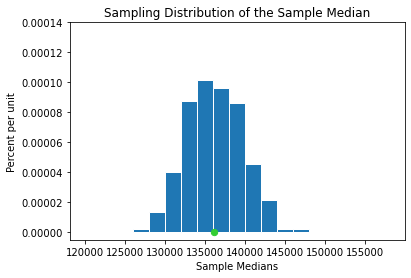

In [256]:
med_bins = np.arange(120000, 160000, 2000)
plt.hist(sample_medians,med_bins, density=True, ec='white');
plt.ylim(-0.000005, 0.00014)
plt.xlabel("Sample Medians")
plt.ylabel("Percent per unit")
plt.title("Sampling Distribution of the Sample Median")
parameter_green = '#32CD32'
plt.scatter(pop_median, 0, color=parameter_green, s=40, zorder=3);

But in the real world we won't be able to keep going back to the population. How to generate a new random sample *without going back to the population?* 

# Bootstrap

Sample randomly:
 - from the original sample
 - with replacement
 - the same number of times as the original sample size

In [287]:
def one_bootstrap_median(our_sample):
    # draw the bootstrap sample
    resample=our_sample.sample(frac=1,replace=True)
    return resample['Total Compensation'].median()


In [254]:
one_bootstrap_median(orig_sample)

139523.0

## Creating a 95% Confidence Interval Using the Percentile Method:  Middle 95% of the Bootstrap Estimates 

[130429.5, 143420.125]

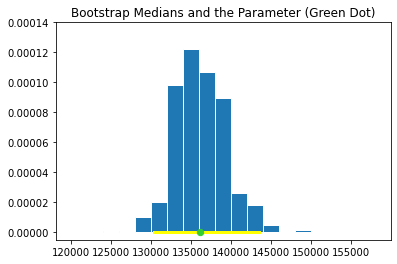

In [290]:
def bootstrapped_median_CI(our_sample, num_boots=1000,hist=False):
     
    #Create array of bootstrapped medians using original sample
    bstrap_medians=np.array([one_bootstrap_median(our_sample) for i in range(num_boots)])    
    
    #Return Bootstrapped 95% Confidence Interval
    L = np.percentile(bstrap_medians,2.5)
    U = np.percentile(bstrap_medians,97.5)
    
    CI = [L, U]
    
    
    if hist==True:
        
        #Plot Histogram of bootstrapped medians
        med_bins = np.arange(120000, 160000, 2000)
        plt.hist(bstrap_medians,bins=med_bins, density=True, ec='white');
        plt.ylim(-0.000005, 0.00014)
        parameter_green = '#32CD32'
    
        #Add plot of actual population median (we don't usually know this)
        plt.scatter(pop_median, 0, color=parameter_green, s=40, zorder=3);
        plt.title('Bootstrap Medians and the Parameter (Green Dot)')
   
  
        #Add Confidence Interval (in yellow) to histogram
        plt.plot(np.array([L, U]), [0,0], color='yellow', lw=3, zorder=1)
    
   
    return CI 
    

bootstrapped_median_CI(orig_sample,hist=True)


### Visualizing the Empirical Coverage of Bootstrapped Confidence Intervals  
*** 

Complete the function CI_test below to test the coverage of the bootstrapped confidence intervals at the 95% confidence level for the median of the Total Compensation.  Recall that you know that the true population median is `pop_median` = 136164

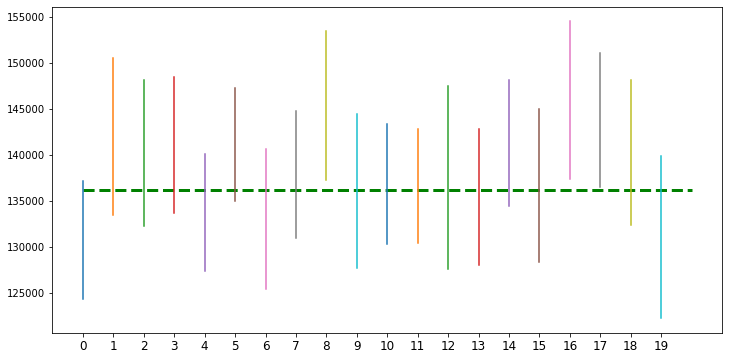

In [261]:
def CI_test(pop_median, num_CIs=100, num_boots=1000):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    
    
    ax.plot([0,num_CIs], [pop_median, pop_median], color="green", ls='--', lw=3)
       # Horizontal line marking the mean
        
    for jj in range(num_CIs):
        # Take a random sample:
        sample1=sf.sample(sample_size,replace=False)
        # Calculate the bootstrapped CI for that sample
        L, U = bootstrapped_median_CI(sample1, num_boots)
        CI = np.array([L, U])
        ax.plot([jj, jj], [L, U])
        
        
            
        
    ax.set_xlim([-1,num_CIs+1])
    plt.xticks(range(num_CIs), fontsize=12)
        
CI_test(pop_median,num_CIs=20, num_boots=1000)
# Call the function